In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [15]:
data = pd.read_csv('data/commute_by_income.csv')
data.head()

,Unnamed: 0,GEOID,location,name,estimate,moe,label,concept,geography
0,1,29189,"St. Louis County, Missouri",B08119_001,491721,2984,Estimate!!Total:,MEANS OF TRANSPORTATION TO WORK BY WORKERS' EA...,tract
1,2,29189,"St. Louis County, Missouri",B08119_002,47288,1871,"Estimate!!Total:!!$1 to $9,999 or loss",MEANS OF TRANSPORTATION TO WORK BY WORKERS' EA...,tract
2,3,29189,"St. Louis County, Missouri",B08119_003,23976,1343,"Estimate!!Total:!!$10,000 to $14,999",MEANS OF TRANSPORTATION TO WORK BY WORKERS' EA...,tract
3,4,29189,"St. Louis County, Missouri",B08119_004,43589,2028,"Estimate!!Total:!!$15,000 to $24,999",MEANS OF TRANSPORTATION TO WORK BY WORKERS' EA...,tract
4,5,29189,"St. Louis County, Missouri",B08119_005,53755,2020,"Estimate!!Total:!!$25,000 to $34,999",MEANS OF TRANSPORTATION TO WORK BY WORKERS' EA...,tract


In [2]:
data = data[['label','estimate','moe']]
data['label'] = data['label'].str.replace('Estimate', '').str.replace('Total', '').str.replace('!!', '').str.replace(':', '')
data.head()

,label,estimate,moe
0,,491721,2984
1,"$1 to $9,999 or loss",47288,1871
2,"$10,000 to $14,999",23976,1343
3,"$15,000 to $24,999",43589,2028
4,"$25,000 to $34,999",53755,2020


In [3]:
trans_totals_mask = ~data['label'].astype(str).str.contains('[$]')
trans_totals = data.loc[trans_totals_mask][1:]
trans_totals

,label,estimate,moe
9,"Car, truck, or van - drove alone",373150,3702
18,"Car, truck, or van - carpooled",30269,1736
27,Public transportation (excluding taxicab),7674,768
36,Walked,6675,763
45,"Taxicab, motorcycle, bicycle, or other means",5161,570
54,Worked from home,68792,2624


In [4]:
income_totals = data[1:9]
income_totals

,label,estimate,moe
1,"$1 to $9,999 or loss",47288,1871
2,"$10,000 to $14,999",23976,1343
3,"$15,000 to $24,999",43589,2028
4,"$25,000 to $34,999",53755,2020
5,"$35,000 to $49,999",76374,2275
6,"$50,000 to $64,999",59651,2063
7,"$65,000 to $74,999",30967,1612
8,"$75,000 or more",156121,2725


In [5]:
all_totals = pd.concat([trans_totals, income_totals])
merged_df = pd.merge(data, all_totals, how='left', indicator=True)
no_totals = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])[1:]

split_data = no_totals['label'].str.split('$', 1, expand=True)
no_totals[['transportation', 'income']] = split_data
no_totals.drop(columns=['label'], inplace=True)
no_totals['income'] = '$' + no_totals['income']

from_this = no_totals['income'].unique()
to_this = [1, 10000, 15000, 25000, 35000, 50000, 65000, 75000]
no_totals['avg income'] = no_totals['income'].replace(from_this, to_this)

no_totals.head()

,estimate,moe,transportation,income,avg income
10,32120,1415,"Car, truck, or van - drove alone","$1 to $9,999 or loss",1
11,17590,1151,"Car, truck, or van - drove alone","$10,000 to $14,999",10000
12,31572,1651,"Car, truck, or van - drove alone","$15,000 to $24,999",15000
13,42589,1824,"Car, truck, or van - drove alone","$25,000 to $34,999",25000
14,61342,1942,"Car, truck, or van - drove alone","$35,000 to $49,999",35000


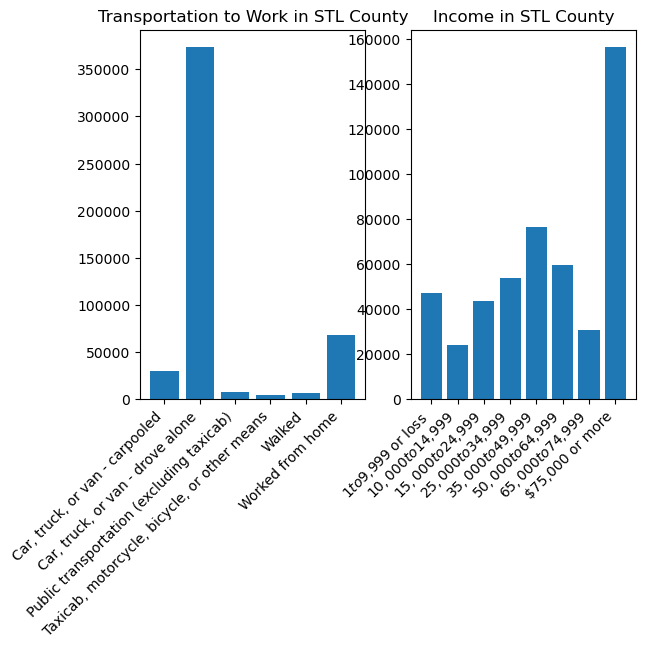

In [6]:
groupby_trans = no_totals.groupby('transportation')['estimate'].sum()
groupby_income = no_totals.groupby('income')['estimate'].sum()

plt.subplot(1,2,1)
plt.bar(groupby_trans.index, groupby_trans)
plt.xticks(rotation=45, ha="right")
plt.title('Transportation to Work in STL County')
plt.subplot(1,2,2)
plt.bar(groupby_income.index, groupby_income)
plt.xticks(rotation=45, ha="right")
plt.title('Income in STL County')
plt.show()

Text(0.5, 1.0, 'Income by Transportation to Work in STL County')

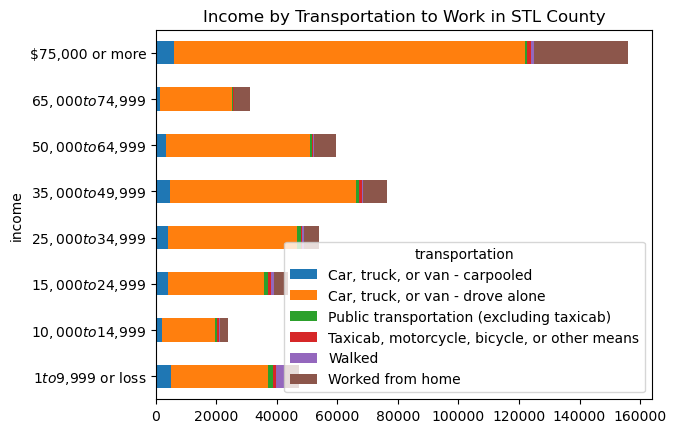

In [7]:
groupby_both = no_totals.groupby(['income', 'transportation'])['estimate'].sum().unstack()
groupby_both.plot(kind='barh', stacked=True)
#plt.xticks(rotation=45, ha="right")
plt.title('Income by Transportation to Work in STL County')

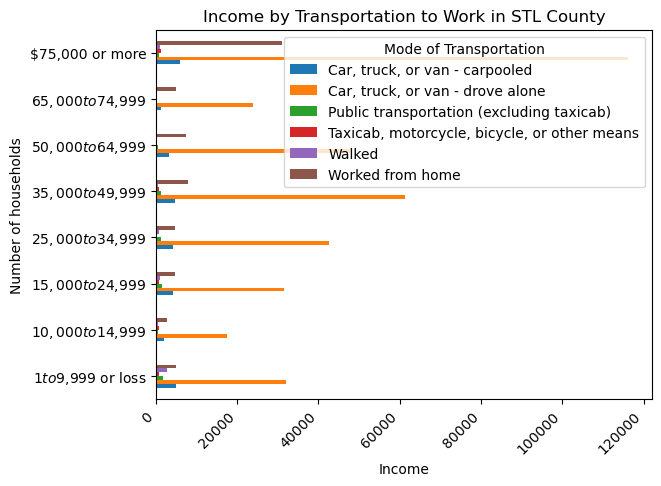

In [8]:
pivot_df = no_totals.pivot(index='income', columns='transportation', values='estimate')

pivot_df.plot(kind='barh')
plt.xlabel('Income')
plt.ylabel('Number of households')
plt.title('Income by Transportation to Work in STL County')
plt.legend(title='Mode of Transportation')
plt.xticks(rotation=45, ha="right")
plt.show()

Text(0.5, 1.0, 'Transportation to Work by Income in STL County')

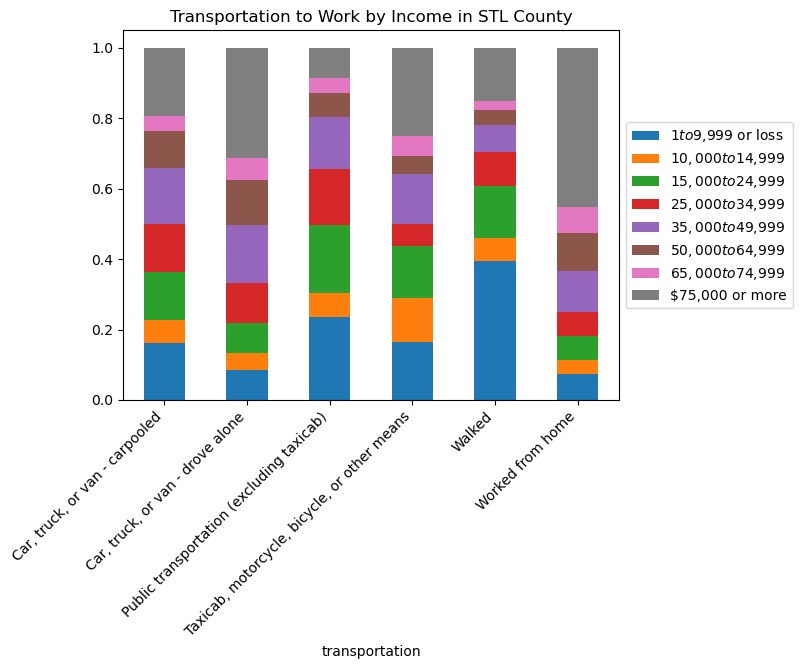

In [9]:
trans_totals.rename(columns={'label': 'transportation'}, inplace=True)
trans_with_percentages = pd.merge(no_totals, trans_totals, on='transportation', suffixes=('_nototals', '_totals'))
trans_with_percentages['income percentage'] = trans_with_percentages['estimate_nototals'] / trans_with_percentages['estimate_totals']

wpg = trans_with_percentages.groupby(['transportation', 'income'])['income percentage'].mean().unstack()
wpg.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45, ha="right")
plt.title('Transportation to Work by Income in STL County')

C:\Users\dodie\miniconda3\envs\cse217a\lib\site-packages\pandas\core\frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 1.0, 'Income by Transportation to Work in STL County')

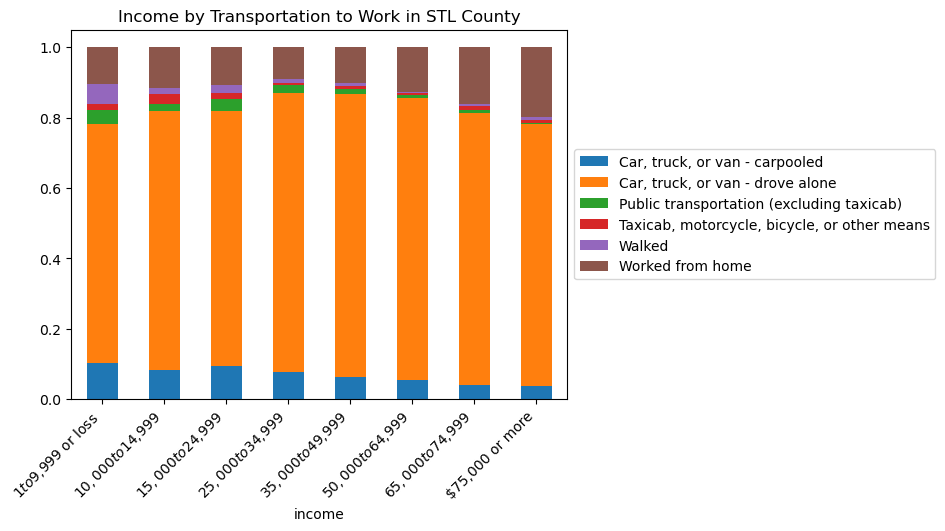

In [10]:
income_totals.rename(columns={'label': 'income'}, inplace=True)
inc_with_percentages = pd.merge(no_totals, income_totals, on='income', suffixes=('_nototals', '_totals'))
inc_with_percentages['transportation percentage'] = inc_with_percentages['estimate_nototals'] / inc_with_percentages['estimate_totals']

wpg = inc_with_percentages.groupby(['income', 'transportation'])['transportation percentage'].mean().unstack()
wpg.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45, ha="right")
plt.title('Income by Transportation to Work in STL County')

Text(0.5, 1.0, 'Percentage of public transportation users by income')

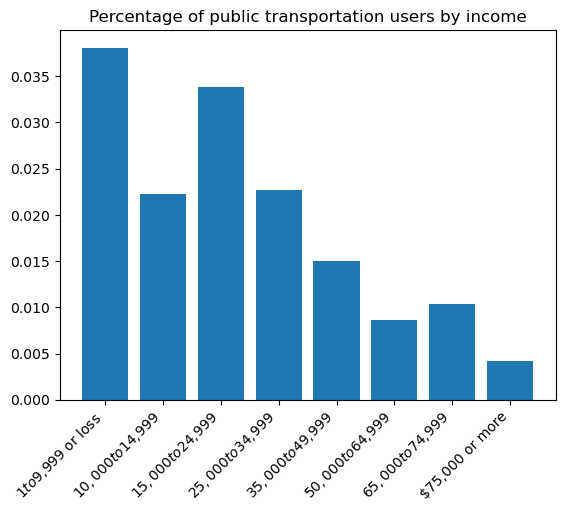

In [25]:
just_public = inc_with_percentages[inc_with_percentages['transportation']=='Public transportation (excluding taxicab)']
plt.bar(just_public['income'],just_public['transportation percentage'])
plt.xticks(rotation=45, ha="right")
plt.title('Percentage of public transportation users by income')